In [24]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
news_df = pd.read_csv('../data/raw_analyst_ratings.csv')
stock_df = pd.read_csv('C:/Users/teeyob/Sentiment-Driven-Financial-Forecasting/data/yfinance_data/AAPL_Historical_data.csv')

In [3]:

news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce').dt.date
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce').dt.date
news_df = news_df.dropna(subset=['date'])
print(news_df['date'])
print(stock_df['Date'])



0          2020-06-05
1          2020-06-03
2          2020-05-26
3          2020-05-22
4          2020-05-22
              ...    
1407266    2018-01-05
1407267    2017-12-06
1407268    2017-12-06
1407269    2017-11-15
1407270    2017-11-14
Name: date, Length: 55987, dtype: object
0        1980-12-12
1        1980-12-15
2        1980-12-16
3        1980-12-17
4        1980-12-18
            ...    
10993    2024-07-24
10994    2024-07-25
10995    2024-07-26
10996    2024-07-29
10997    2024-07-30
Name: Date, Length: 10998, dtype: object


In [4]:
nat_count = news_df['date'].isna().sum()
print(f"Number of NaT values: {nat_count}")


Number of NaT values: 0


In [5]:
sia = SentimentIntensityAnalyzer()
def analyze_sentiment(headline):
    score = sia.polarity_scores(headline)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'


news_df['sentiment'] = news_df['headline'].apply(analyze_sentiment)

print(news_df[['headline', 'sentiment']])


                                                  headline sentiment
0                  Stocks That Hit 52-Week Highs On Friday   neutral
1               Stocks That Hit 52-Week Highs On Wednesday   neutral
2                            71 Biggest Movers From Friday   neutral
3             46 Stocks Moving In Friday's Mid-Day Session   neutral
4        B of A Securities Maintains Neutral on Agilent...  positive
...                                                    ...       ...
1407266  Chinese Nano-Cap Momentum Stocks Sharply Highe...  positive
1407267  28 Stocks Moving In Wednesday's Pre-Market Ses...   neutral
1407268  China Zenix Auto International Reports Q3 EPAD...   neutral
1407269                   46 Biggest Movers From Yesterday   neutral
1407270      42 Stocks Moving In Tuesday's Mid-Day Session   neutral

[55987 rows x 2 columns]


In [6]:

sia = SentimentIntensityAnalyzer()

def analyze_sentiment(headline):
    score = sia.polarity_scores(headline)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

news_df['sentiment'] = news_df['headline'].apply(analyze_sentiment)

sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
news_df['sentiment_score'] = news_df['sentiment'].map(sentiment_mapping)

daily_sentiment = news_df.groupby('date')['sentiment_score'].mean().reset_index()

daily_sentiment.columns = ['date', 'average_sentiment_score']

print(daily_sentiment)


            date  average_sentiment_score
0     2011-04-27                 0.000000
1     2011-04-28                 0.500000
2     2011-04-29                 0.500000
3     2011-04-30                 1.000000
4     2011-05-01                 0.000000
...          ...                      ...
2523  2020-06-07                 0.160000
2524  2020-06-08                 0.423529
2525  2020-06-09                 0.414179
2526  2020-06-10                 0.070720
2527  2020-06-11                 0.400735

[2528 rows x 2 columns]


In [7]:

stock_df = stock_df.sort_values(by='Date')

stock_df['daily_return'] = stock_df['Adj Close'].pct_change() * 100  

print(stock_df[['Date', 'Adj Close', 'daily_return']])


             Date   Adj Close  daily_return
0      1980-12-12    0.098943           NaN
1      1980-12-15    0.093781     -5.217059
2      1980-12-16    0.086898     -7.339761
3      1980-12-17    0.089049      2.475074
4      1980-12-18    0.091630      2.899199
...           ...         ...           ...
10993  2024-07-24  218.287323     -2.875430
10994  2024-07-25  217.238556     -0.480453
10995  2024-07-26  217.708008      0.216100
10996  2024-07-29  217.987686      0.128465
10997  2024-07-30  218.547043      0.256600

[10998 rows x 3 columns]


In [8]:


merged_df = pd.merge(daily_sentiment, stock_df[['Date', 'daily_return']], left_on='date', right_on='Date')

merged_df = merged_df.dropna()

correlation = merged_df[['average_sentiment_score', 'daily_return']].corr().iloc[0, 1]

print(f"Pearson Correlation Coefficient: {correlation}")


Pearson Correlation Coefficient: 0.04851964709628916


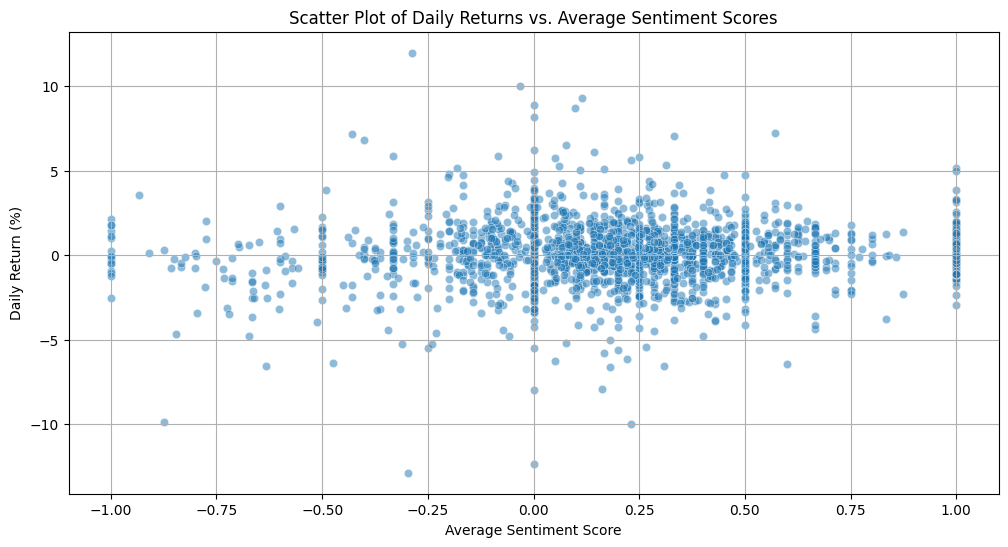

In [9]:


plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df, x='average_sentiment_score', y='daily_return', alpha=0.5)

plt.title('Scatter Plot of Daily Returns vs. Average Sentiment Scores')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Daily Return (%)')

# Show the plot
plt.grid(True)
plt.show()


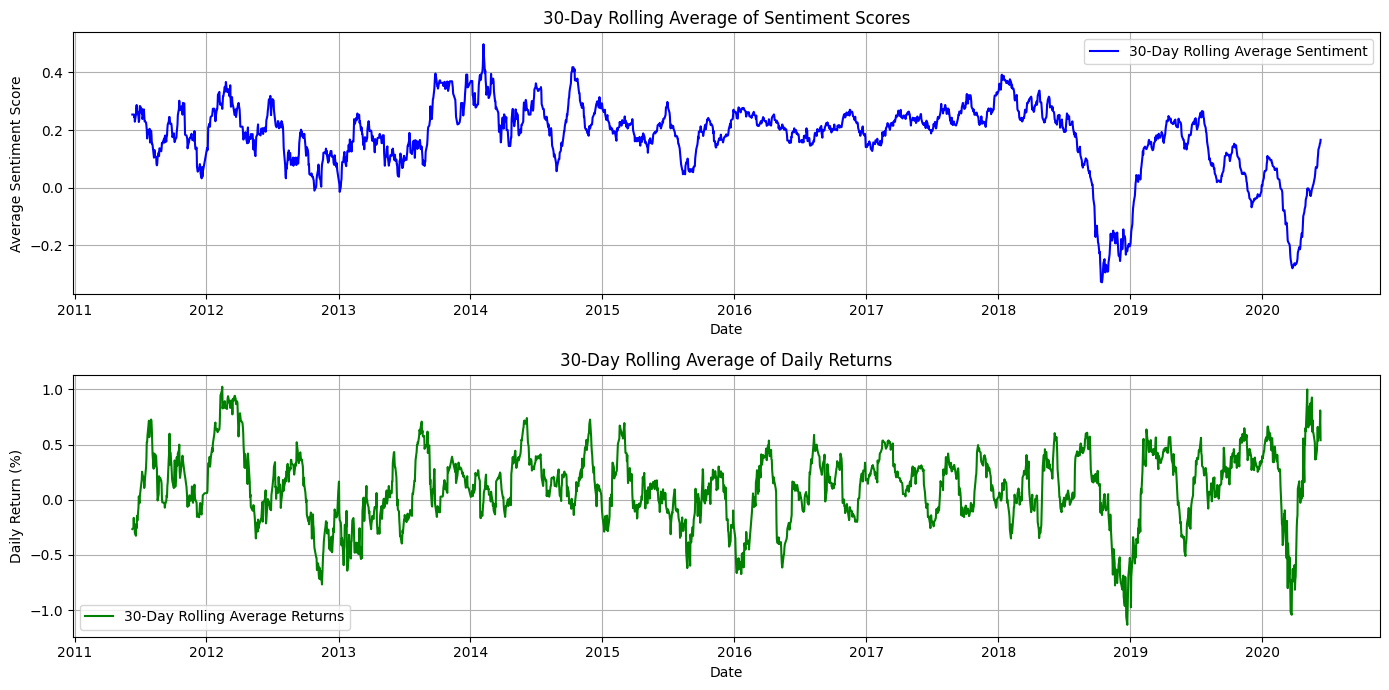

In [10]:


daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

merged_df = pd.merge(daily_sentiment, stock_df[['Date', 'daily_return']], left_on='date', right_on='Date')

merged_df = merged_df.dropna()

merged_df['sentiment_rolling_avg'] = merged_df['average_sentiment_score'].rolling(window=30).mean()
merged_df['returns_rolling_avg'] = merged_df['daily_return'].rolling(window=30).mean()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(merged_df['date'], merged_df['sentiment_rolling_avg'], label='30-Day Rolling Average Sentiment', color='blue')
plt.title('30-Day Rolling Average of Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(merged_df['date'], merged_df['returns_rolling_avg'], label='30-Day Rolling Average Returns', color='green')
plt.title('30-Day Rolling Average of Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
merged_df

,date,average_sentiment_score,Date,daily_return,sentiment_rolling_avg,returns_rolling_avg
0,2011-04-27,0.000000,2011-04-27,-0.077089,NaN,NaN
1,2011-04-28,0.500000,2011-04-28,-0.970980,NaN,NaN
2,2011-04-29,0.500000,2011-04-29,0.974774,NaN,NaN
3,2011-05-02,0.444444,2011-05-02,-1.099603,NaN,NaN
4,2011-05-03,0.000000,2011-05-03,0.554439,NaN,NaN
...,...,...,...,...,...,...
2221,2020-06-05,0.624464,2020-06-05,2.848089,0.132290,0.642865
2222,2020-06-08,0.423529,2020-06-08,0.591234,0.144782,0.566341
2223,2020-06-09,0.414179,2020-06-09,3.157814,0.153170,0.669245
2224,2020-06-10,0.070720,2020-06-10,2.572742,0.154265,0.809034


In [13]:
merged_df['Date'] = pd.to_numeric(merged_df['Date'], errors='coerce')
#merged_df = merged_df.dropna()

In [14]:

X = merged_df[['average_sentiment_score', 'Date']]  # Features
y = merged_df['daily_return'] 
merged_df
X

,average_sentiment_score,Date
0,0.000000,1303862400000000000
1,0.500000,1303948800000000000
2,0.500000,1304035200000000000
3,0.444444,1304294400000000000
4,0.000000,1304380800000000000
...,...,...
2221,0.624464,1591315200000000000
2222,0.423529,1591574400000000000
2223,0.414179,1591660800000000000
2224,0.070720,1591747200000000000


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 3.330168431780938


In [23]:
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print('Model saved to sentiment_model.pkl')

Model saved to sentiment_model.pkl
